In [96]:
from tensorflow.keras.utils import to_categorical
import pandas as pd
from pandas import read_excel
import numpy as np
import re
from re import sub
import multiprocessing
from unidecode import unidecode
import os
from time import time 
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import LSTM,Dense,Dropout,Activation,Embedding,Flatten,Bidirectional,MaxPooling2D, Conv1D, MaxPooling1D
from keras.optimizers import SGD,Adam
from keras import regularizers
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
import h5py
import csv
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.model_selection import StratifiedKFold

In [97]:
def text_to_word_list(text):
    text = text.split()
    return text

def replace_strings(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           u"\u00C0-\u017F"          #latin
                           u"\u2000-\u206F"          #generalPunctuations
                               
                           "]+", flags=re.UNICODE)
    english_pattern=re.compile('[a-zA-Z0-9]+', flags=re.I)
    #latin_pattern=re.compile('[A-Za-z\u00C0-\u00D6\u00D8-\u00f6\u00f8-\u00ff\s]*',)
    
    text=emoji_pattern.sub(r'', text)
    text=english_pattern.sub(r'', text)

    return text

def remove_punctuations(my_str):
    # define punctuation
    punctuations = '''````£|¢|Ñ+-*/=EROero৳০১২৩৪৫৬৭৮৯012–34567•89।!()-[]{};:'"“\’,<>./?@#$%^&*_~‘—॥”‰⚽️✌�￰৷￰'''
    
    no_punct = ""
    for char in my_str:
        if char not in punctuations:
            no_punct = no_punct + char

    # display the unpunctuated string
    return no_punct



def joining(text):
    out=' '.join(text)
    return out

def preprocessing(text):
    out=remove_punctuations(replace_strings(text))
    return out

In [98]:
train_url = '/kaggle/input/revised-corrector-dataset/train_corr.csv'
test_url = '/kaggle/input/revised-corrector-dataset/test_corr.csv'
df_train = pd.read_csv(train_url)
df_test = pd.read_csv(test_url)
stop_words_df = pd.read_excel('/kaggle/input/bangla-stopwords/stopwords_bangla.xlsx',index_col=False)
STOPWORDS = set([word.strip() for word in stop_words_df['words']])

In [99]:
df_train['Comment'] = df_train.Comment.apply(lambda x: preprocessing(str(x)))
df_test['Comment'] = df_test.Comment.apply(lambda x:preprocessing(str(x)))

In [100]:
train1, test1 = df_train,df_test
training_sentences = []
testing_sentences = []



train_sentences=df_train['Comment'].values
train_labels=df_train['Error'].values
for i in range(train_sentences.shape[0]): 
    #print(train_sentences[i])
    x=str(train_sentences[i])
    training_sentences.append(x)
    
training_sentences=np.array(training_sentences)





test_sentences=df_test['Comment'].values
test_labels=df_test['Error'].values

for i in range(test_sentences.shape[0]): 
    x=str(test_sentences[i])
    testing_sentences.append(x)
    
testing_sentences=np.array(testing_sentences)


train_labels=keras.utils.to_categorical(train_labels)


test_labels=keras.utils.to_categorical(test_labels)
print("Training Set Length: "+str(len(train1)))
print("Testing Set Length: "+str(len(test1)))
print("training_sentences shape: "+str(training_sentences.shape))
print("testing_sentences shape: "+str(testing_sentences.shape))
print("train_labels shape: "+str(train_labels.shape))
print("test_labels shape: "+str(test_labels.shape))


Training Set Length: 20083
Testing Set Length: 5022
training_sentences shape: (20083,)
testing_sentences shape: (5022,)
train_labels shape: (20083, 2)
test_labels shape: (5022, 2)


In [101]:
vocab_size = 25000
embedding_dim = 300
max_length = 100
trunc_type='post'
oov_tok = "<OOV>"

In [102]:
tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)
word_index = tokenizer.word_index
print(len(word_index))
print("Word index length:"+str(len(tokenizer.word_index)))
sequences = tokenizer.texts_to_sequences(training_sentences)
padded = pad_sequences(sequences,maxlen=max_length, truncating=trunc_type)


test_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(test_sequences,maxlen=max_length)

28623
Word index length:28623


In [103]:
print("Sentence :--> \n")
print(training_sentences[2]+"\n")
print("Sentence Tokenized and Converted into Sequence :--> \n")
print(str(sequences[2])+"\n")
print("After Padding the Sequence with padding length 100 :--> \n")
print(padded[2])

Sentence :--> 

অনেক সুন্দর অভিনয় করেন উনি আমার অনেক ভালো লাগে

Sentence Tokenized and Converted into Sequence :--> 

[4, 11, 377, 138, 330, 6, 4, 5, 44]

After Padding the Sequence with padding length 100 :--> 

[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   4  11 377 138 330   6   4   5  44]


In [104]:
print("Padded shape(training): "+str(padded.shape))
print("Padded shape(testing): "+str(testing_padded.shape))

Padded shape(training): (20083, 100)
Padded shape(testing): (5022, 100)


In [105]:
with tf.device('/gpu:0'):
    model= Sequential()
    model.add(Embedding(vocab_size, embedding_dim, input_length=max_length))
    model.add(Conv1D(200, kernel_size=3, activation = "relu"))
    model.add(Bidirectional(LSTM(64, return_sequences=True)))
    model.add(Dropout(0.5))
    model.add(Bidirectional(LSTM(64)))
    model.add(Dense(50, activation='relu'))
    model.add(Dense(50, activation='relu'))
    model.add(Flatten())
    #l2 regularizer
    model.add(Dense(100,kernel_regularizer=regularizers.l2(0.01),activation="relu"))
    model.add(Dense(2, activation='softmax'))
    #sgd= SGD(lr=0.0001,decay=1e-6,momentum=0.9,nesterov=True)
    adam=Adam(learning_rate=0.0005,beta_1=0.9,beta_2=0.999,epsilon=1e-07,amsgrad=False)
    model.summary()
    model.compile(loss='categorical_crossentropy',optimizer=adam,metrics=['accuracy'])

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 100, 300)          7500000   
                                                                 
 conv1d_1 (Conv1D)           (None, 98, 200)           180200    
                                                                 
 bidirectional_7 (Bidirectio  (None, 98, 128)          135680    
 nal)                                                            
                                                                 
 dropout_5 (Dropout)         (None, 98, 128)           0         
                                                                 
 bidirectional_8 (Bidirectio  (None, 128)              98816     
 nal)                                                            
                                                                 
 dense_15 (Dense)            (None, 50)               

In [106]:
    history=model.fit(padded,train_labels,epochs=6,batch_size=256,validation_data=(testing_padded,test_labels),use_multiprocessing=True, workers=8)

Epoch 1/6
79/79 [==============================] - 12s 66ms/step - loss: 1.1171 - accuracy: 0.6547 - val_loss: 1.1551 - val_accuracy: 0.6926
Epoch 2/6
79/79 [==============================] - 4s 46ms/step - loss: 0.6598 - accuracy: 0.8298 - val_loss: 1.1671 - val_accuracy: 0.7164
Epoch 3/6
79/79 [==============================] - 4s 46ms/step - loss: 0.3584 - accuracy: 0.9255 - val_loss: 1.2309 - val_accuracy: 0.7220
Epoch 4/6
79/79 [==============================] - 4s 46ms/step - loss: 0.2058 - accuracy: 0.9603 - val_loss: 1.4133 - val_accuracy: 0.7274
Epoch 5/6
79/79 [==============================] - 4s 46ms/step - loss: 0.1278 - accuracy: 0.9772 - val_loss: 1.5426 - val_accuracy: 0.7250
Epoch 6/6
79/79 [==============================] - 4s 46ms/step - loss: 0.0826 - accuracy: 0.9850 - val_loss: 1.6741 - val_accuracy: 0.7264


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


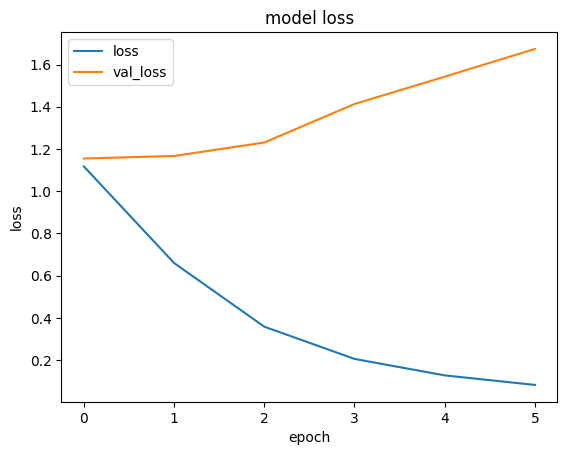

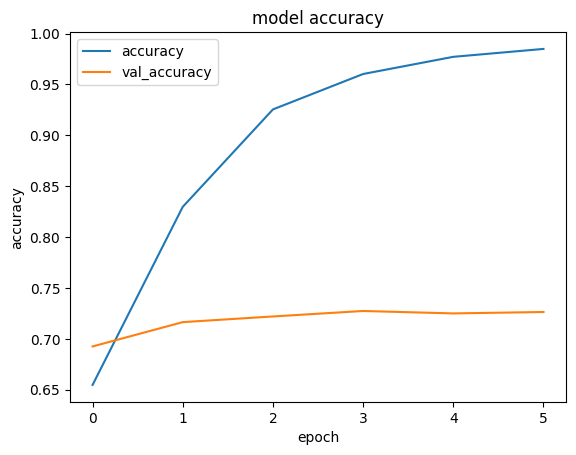

In [107]:
print(history.history.keys())
loss = history.history['loss']
val_loss = history.history['val_loss']
plt.plot(loss)
plt.plot(val_loss)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['loss', 'val_loss'])
plt.show()

accuracy = history.history['accuracy']
val_accuracy= history.history['val_accuracy']
plt.plot(accuracy)
plt.plot(val_accuracy)
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['accuracy', 'val_accuracy'])
plt.show()

In [108]:
#accuracy calculation
loss_and_metrics = model.evaluate(padded,train_labels,batch_size=256)
print("The train accuracy is: "+str(loss_and_metrics[1]))
loss_and_metrics = model.evaluate(testing_padded,test_labels,batch_size=256)
print("The test accuracy is: "+str(loss_and_metrics[1]))

79/79 [==============================] - 1s 15ms/step - loss: 0.0548 - accuracy: 0.9925
The train accuracy is: 0.9925310015678406
20/20 [==============================] - 0s 15ms/step - loss: 1.6741 - accuracy: 0.7264
The test accuracy is: 0.7264038324356079


In [109]:
pred = (model.predict(testing_padded) > 0.5).astype("int32")

157/157 [==============================] - 2s 7ms/step


In [110]:
from sklearn.metrics import classification_report
print(classification_report(test_labels, pred, target_names = ['Correct','Incorrect']))

              precision    recall  f1-score   support

     Correct       0.74      0.43      0.54      1910
   Incorrect       0.72      0.91      0.80      3112

   micro avg       0.73      0.73      0.73      5022
   macro avg       0.73      0.67      0.67      5022
weighted avg       0.73      0.73      0.71      5022
 samples avg       0.73      0.73      0.73      5022

